# Homework 4

- Execute the below code, then answer the numbered questions.

# Import Libraries

In [23]:
import warnings
warnings.filterwarnings('ignore')


from platform import version
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

import matplotlib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge


# Version Control

In [2]:
print(f'Python Version: {version()}')
print(f'Pandas Version: {pd.__version__}')
print(f'Matplotlib Version: {matplotlib.__version__}')
print(f'Seaborn Version: {sns.__version__}')

Python Version: 10.0.22621
Pandas Version: 1.3.4
Matplotlib Version: 3.4.3
Seaborn Version: 0.11.2


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/regression/car-reg-data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055 entries, 0 to 9054
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   make           8164 non-null   object 
 1   transmission   8106 non-null   object 
 2   state          8152 non-null   object 
 3   condition      8173 non-null   float64
 4   odometer       8178 non-null   float64
 5   auction_value  8107 non-null   float64
 6   selling_price  9055 non-null   float64
dtypes: float64(4), object(3)
memory usage: 495.3+ KB


In [4]:
features = [x for x in df.columns if x != 'selling_price']

X = df[features]
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

print(f'Records in training data: {X_train.shape[0]:,}')
print(f'Records in test data: {X_test.shape[0]:,}')
print('\nFeatures:')
print(*X_train.columns, sep='\n')

Records in training data: 7,244
Records in test data: 1,811

Features:
make
transmission
state
condition
odometer
auction_value


## Question 1: Split the features into two lists, one for the numerical features and another for the categorical features.

In [5]:
num_features = [col for col in features if df[col].dtype == float]
cat_features = [col for col in features if col not in num_features]

## Question 2: Using the numerical variables, create a pipeline that replaces the missing values with the median and then standardizes the values using a standard scaler.

In [6]:
num_pipeline = Pipeline( [('imputer missing', SimpleImputer(strategy='median')),
                         ('standardize', StandardScaler())])

## Question 3: Using the categorical variables, create a pipeline that replaces the missing values with the most frequent and then use one-hot encoding to convert the data to numerical arrays.
- You should be dropping one category from each variable when using the one-hot encoder.  
- To ensure the pipeline doesn't break when it receives new/unexpected categories, you should ignore new categories.
- Use a fit transformer on the training dataset to validate all the columns are now numeric and to determine how many columns the transformed data contains.

In [7]:
cat_pipeline = Pipeline([('imputer missing', SimpleImputer(strategy='most_frequent')),
                         ('one hot encoding', OneHotEncoder( drop = 'first'))])

In [8]:
ct = ColumnTransformer(transformers=[('cat_features', cat_pipeline, cat_features)])
ct.fit_transform(X_train)

<7244x41 sparse matrix of type '<class 'numpy.float64'>'
	with 14213 stored elements in Compressed Sparse Row format>

**Here we can that data has 7244 rows and 41 columns.**

---
## Question 4: Combine the numerical and categorical pipelines into one data processing pipeline.
- Use a fit transformers and the training dataset to verify the data has no missing values and the correct number of columns.

In [9]:
df['make'].nunique() + 9

19

In [10]:
cols = 0
for col in cat_features:
    cols += df[col].nunique()

print(f' Total number of columns after transformation should be {cols}')

 Total number of columns after transformation should be 44


In [11]:
# insert code here
procesing_pipeline = ColumnTransformer(transformers=[('num_features', num_pipeline, num_features),
                                                    ('cat_features', cat_pipeline, cat_features),])

In [12]:
logs = procesing_pipeline.fit_transform(X_train)

In [13]:
logs

<7244x44 sparse matrix of type '<class 'numpy.float64'>'
	with 35945 stored elements in Compressed Sparse Row format>

In [14]:
pd.DataFrame(logs).isna().sum().sum()

0

**Here we can that all the columns are folat type. And has 7244 rows and 44 columns.**

**Also, there are no missing values in the data.**

---
## Question 5: Add a linear regression model to the pipeline.
- Report what the $R^2$ is using the `test` data.  

In [15]:
modeling_pipeline = Pipeline([('data_preprocessing', procesing_pipeline),
                             ('Model', LinearRegression())])

modeling_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('num_features',
                                                  Pipeline(steps=[('imputer '
                                                                   'missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['condition', 'odometer',
                                                   'auction_value']),
                                                 ('cat_features',
                                                  Pipeline(steps=[('imputer '
                                                                   'missing',
                                                                   SimpleImputer(strategy='most_fre

In [16]:
preds = modeling_pipeline.predict(X_test)

In [17]:
r2 = r2_score(preds, y_test)
print(f'the r2 score is : {r2}')

the r2 score is : 0.8656553005611491


## Question 6: Create a plot(s) of the residuals. Do you have any concerns about patterns in the residuals that the model is neglecting to pick-up?
- Include a sentence or two on what you observe.

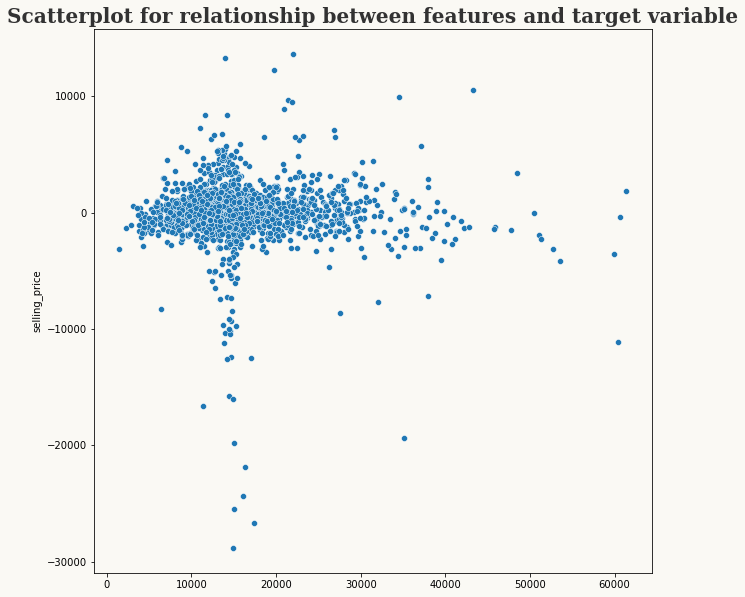

In [18]:
color_palette = ["#eeb977","#8d9e8c"]

fig = plt.figure(figsize = (10, 10))
gs = fig.add_gridspec(1, 1)

ax0 = fig.add_subplot(gs[0, 0])

background_color = "#faf9f4"
fig.patch.set_facecolor(background_color) # figure background color

ax0.set_facecolor(background_color) # axes background color

sns.scatterplot(x = preds, y = preds-y_test, ax = ax0)


_ = plt.title('Scatterplot for relationship between features and target variable',fontsize=20, y = 1, x = 0.5, fontweight='bold', fontfamily='serif', color="#323232")

**As we can see in the scatterplot, that most of the values are around zero which means our model is giving generalized predictions for most of the instances.**

---
## Question 7: Modify the pipeline to use a ridge regression model with an alpha value of 100. How does this change the $R^2$?

In [19]:

modeling_pipeline = Pipeline([('data_preprocessing', procesing_pipeline),
                             ('Model', Ridge(alpha=100))])

modeling_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('num_features',
                                                  Pipeline(steps=[('imputer '
                                                                   'missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['condition', 'odometer',
                                                   'auction_value']),
                                                 ('cat_features',
                                                  Pipeline(steps=[('imputer '
                                                                   'missing',
                                                                   SimpleImputer(strategy='most_fre

In [20]:
result = modeling_pipeline.predict(X_test)

r2 = r2_score(result, y_test)
print(f'the r2 score is : {r2}')

the r2 score is : 0.860666343019207


**The r2 score is slightly decreased**